In [1]:
%matplotlib notebook

In this script, fish trajectories are first discretized into scoots.

The 'scoot' is then the fundamental unit which is used to analyze the data. Check Figure 4f for a visual overview of how scoots are defined. 

Each scoot is assumed to be a straight movement while reorientation maneuvers only happen in between scoots. This reorientation angle is termed $\theta$.

In Figure 4g we show that in the experimental condition $\theta$ is significantly higher compare to the control in low light conditions.

In Figure 4h we show that this can be explained by only considering scoots that are down the light gradient.

This indicates a simple mechanism for fish to manage to stay close to a virtual white light source: Make large turns if you are experiencing a decrease in light intensity. This is similar to what was found in  [Chen & Engert 2014](https://www.frontiersin.org/articles/10.3389/fnsys.2014.00039/full)

In [2]:
import numpy as np
import os
from glob import glob
import json
import pandas as pd
from skimage import draw
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import pickle
from scipy.ndimage.interpolation import affine_transform
from scipy import stats
import matplotlib.patches as mpatches
from pathlib import Path
import shared_functions
import statsmodels.api as sm

In [3]:
home_path = os.getcwd()
# set to True to save plots
save_plot = False

data_path = Path(home_path, 'data/gaussian_arena/')
data_path_ctr = Path(home_path, 'data/control/')
# all the figures will be saved in this folder
target_path = Path(home_path, 'plots/')
Path(target_path).mkdir(parents=True, exist_ok=True) 

In [4]:
def calculate_theta(path, control = False):
    """
    This function calculates theta for each scoot and returns a list of the 
    1. timepoints of the scoots
    2. theta of each scoot
    3. light intensity experienced in the previous scoot
    
    """
    folders = [x for x in path.iterdir() if x.is_dir()]

    arena_max_coordinates = np.zeros((2,len(folders)))

    all_counted_scoots = []
    all_angles_light = []
    all_angle = []
    all_angle_relative_to_light = []
    all_not_counted = []


    # Go through each experimental folder, collect relevant data and calculate
    # distance to source
    for i, folder_name in enumerate(folders):
        print('Analyzing ' + folder_name.parts[-1])

        files = [x for x in folder_name.iterdir() if x.is_file()]
        # find the data_file.csv to get the distance to source of the centroid
        for file in files:
            if 'data.csv' in file.parts[-1]:
                data = pd.read_csv(file)


        with open((Path(folder_name,'experiment_settings.json')), 'r') as file:
            experiment_settings = json.load(file)
            fps = experiment_settings['Framerate']
            pixel_per_mm = experiment_settings['Pixel per mm']
            dish_center_x = experiment_settings['Dish Center X']
            dish_center_y = experiment_settings['Dish Center Y']
            dish_diameter = experiment_settings['Dish Diameter']

        if i == 0:
            mask_to_indicate_dish = np.zeros((480,640, len(folders)),dtype=np.bool_)

        rr, cc = draw.circle(dish_center_y, dish_center_x, dish_diameter, shape = (480,640))
        mask_to_indicate_dish[rr,cc,i] = True

        y = np.asarray(data['Y-Centroid'])
        x = np.asarray(data['X-Centroid'])

        if i == 0:
            centroid_coordinates = np.zeros((x.shape[0],2,len(folders)))
            all_centroid_coordinates_filt = np.zeros((x.shape[0],2,len(folders)))
        centroid_coordinates[:, 0, i] = y
        centroid_coordinates[:, 1, i] = x

        # filter x/y coordinates using the half-triangle
        centroid_filt_y =  np.floor(np.convolve(y,shared_functions.constants.kernel_centroid,'same'))
        centroid_filt_x =  np.floor(np.convolve(x,shared_functions.constants.kernel_centroid,'same'))
        centroid_filt = np.asarray((centroid_filt_y, centroid_filt_x)).T

        all_centroid_coordinates_filt[:,:,i]= centroid_filt
        # calculated speed:
        centroid_speed_filt = []
        for i_speed in range(centroid_filt.shape[0]):
            centroid_speed_filt.append((np.linalg.norm(centroid_filt[i_speed, :,] 
                                                       - centroid_filt[i_speed - 1,:] ) 
                                                       / pixel_per_mm) 
                                                       * fps)

        # list to numpy array:
        centroid_speed_filt = np.asarray(centroid_speed_filt)
        # convolve to do the triangular filtering
        filt_centroid_speed_filt =  np.convolve(centroid_speed_filt,
                                                shared_functions.constants.kernel_speed,
                                                'same')

        #centroid_speed_filt_pd = pd.Series(centroid_speed_filt)
        #speed_filtered_centroid_speed = centroid_speed_filt_pd.rolling(window=fps, win_type='triang').mean()
        if i == 0:
            filtered_speed_gauss_np = np.zeros((len(centroid_filt), len(folders)))

        filtered_speed_gauss_np[:,i] = np.asarray(filt_centroid_speed_filt).copy()

        # In control experiments no virtual arena was saved - need to reconstruct post-hoc what the arena
        # would have looked like
        virtual_arena = None
        if control:
            data_first_frame = []
            with (open(Path(folder_name, 'first_frame_data.pkl'), 'rb')) as openfile:
                while True:
                    try:
                        data_first_frame.append(pickle.load(openfile))
                    except EOFError:
                        break
            # adjust the arena according to the first frame
            virtual_arena = shared_functions.adjust_VR_arena_to_animal(data_first_frame, 
                                                                       centroid_coordinates[:,:,i],
                                                                       home_path)
        # In experiment condition, just read the used virtual arena
        else:
            # get the arena
            for file in files:
                if 'csv' and '640x480' in file.parts[-1]:
                        virtual_arena = np.genfromtxt(file, delimiter=',')
                        
        if i == 0:
            all_virtual_arena = np.zeros((virtual_arena.shape[0], virtual_arena.shape[1], len(folders)))
        all_virtual_arena[:,:,i] = virtual_arena.copy()

        # Get the maximum xy coordinate of the arena (different for different experiment as it depends on the position of 
        # the animal)
        max_arena_indices = np.where(virtual_arena == np.amax(virtual_arena))
        # just the the first one as there are only two anyways and it's only used to center the image
        arena_max_coordinates[:,i] = max_arena_indices[0][0], max_arena_indices[1][0]
        
        if i == 0:
            distance_to_source = np.zeros((x.shape[0],len(folders)))
        # Calculate the eucledian distance for each coordinate  
        for j in range(all_centroid_coordinates_filt.shape[0]):
            distance_to_source[j,i] = np.linalg.norm(all_centroid_coordinates_filt[j,:,i] \
                                                     - arena_max_coordinates[:,i])\
                                                     / pixel_per_mm

        # Alternative way of finding peaks - just use the supplied scipy function directly on the array
        identified_scoots, temp = find_peaks(x = filtered_speed_gauss_np[:,i],
                                             height = shared_functions.constants.speed_scoot,
                                             distance = shared_functions.constants.min_frames_between_scoots,
                                             width = shared_functions.constants.minimum_length_of_scoot
                                 )
        #print(identified_scoots)

        # next, calculate orientation during scoot relative to light source
        # use the following three points:
        # 1) the x and y position ~100ms before the scoot maximum
        # 2) the x and y position ~100ms after the scoot maximum
        # 3) the x and y position of the source
        #
        # First, calculate the (absolute) angle of the animal by defining the angle of the scoot:
        # angle_animal = after - before
        # Second, calculate the angle between the position ~100ms after the scoot (heading/front) and the source:
        # source - after
        # angle_front_source = then simply subtract the angle_front_source from angle_animal

        y_source = arena_max_coordinates[0,i]
        x_source = arena_max_coordinates[1,i]

        all_counted_scoots_temp, all_angles_light_temp,angles_rel_to_light_temp, all_angle_temp, not_counted_scoots \
                = shared_functions.define_counted_scoots(identified_peaks = identified_scoots,
                                                         scoot_time = shared_functions.constants.scoot_time,
                                                         centroid_coords = centroid_coordinates[:, :, i],
                                                         y_source = y_source,
                                                         x_source = x_source)
        all_counted_scoots.append(all_counted_scoots_temp)
        
        all_angles_light.append(all_angles_light_temp)

        all_angle_relative_to_light.append(np.asarray(angles_rel_to_light_temp))

        all_angle.append(all_angle_temp)
        
        all_not_counted.append(not_counted_scoots)
                
        # Now get all the stimulation values! 
        # To keep everything as similar as possible, treat the experimental condition
        # the same as the control even though the stimulation values would be directly
        # available in data['stimulation']. 
        # For each timepoint in each experiment, go through the x/y coordinates, check
        # in the virtual arena what the stimulation value would be and safe.
        
        # Note: In control condition, the arena was originally designed using uint16 number space
        # (0..65535). The GPIO's only take values from 0..40000. When PiVR takes the arena and 
        # prepares it for an experiment, it adjusts the values to 0..40000
        # In the control condition, the arena is still in uint16 number space and the values 
        # therefore need to be normalied from 0..65535 to 0..40000 to be compared to the exp. 
        # stimulus. That's why there's a 'if control' clause in here.
        if i == 0:
            all_stimulation = np.zeros((data.shape[0], len(folders)))
        for i_stim in range(all_stimulation.shape[0]):
            try:
                raw_stim = virtual_arena[int(data['Y-Centroid'][i_stim]),
                                         int(data['X-Centroid'][i_stim])]
                if control:
                    all_stimulation[i_stim,i] = raw_stim*(40000/65535) # Same as in original experiment
                else:
                    all_stimulation[i_stim,i] = raw_stim
            except ValueError:
                all_stimulation[i_stim,i] = np.nan
        
    return(all_counted_scoots, 
           all_angle, 
           all_stimulation,
           all_angle_relative_to_light,
           arena_max_coordinates,
           filtered_speed_gauss_np,
           distance_to_source,
           all_not_counted)#,
           # all_centroid_coordinates_filt,
           # all_virtual_arena)

In [5]:
scoots_exp, theta_exp, stim_exp, angle_to_light_exp, vr_source_exp, centroids_exp, DTS_exp,not_counted = calculate_theta(path=data_path)

Analyzing 01.07.2018_12-24-50_Casper AB


C:\Users\David\AppData\Local\conda\conda\envs\pivr_publication\lib\site-packages\ipykernel_launcher.py:127: PeakPropertyWarning: some peaks have a width of 0


Analyzing 01.07.2018_14-25-37_Casper AB
Analyzing 01.07.2018_14-56-01_Casper AB
Analyzing 01.07.2018_15-15-17_Casper AB
Analyzing 01.07.2018_15-21-37_Casper AB
Analyzing 01.07.2018_15-31-53_Casper AB
Analyzing 01.07.2018_15-45-35_Casper AB
Analyzing 01.07.2018_16-28-07_Casper AB
Analyzing 01.07.2018_16-38-07_Casper AB
Analyzing 01.07.2018_16-56-10_Casper AB
Analyzing 01.07.2018_17-05-04_Casper AB
Analyzing 01.07.2018_18-16-36_Casper AB
Analyzing 01.07.2018_18-49-55_Casper AB


In [6]:
scoots_ctr, theta_ctr, stim_ctr, angle_to_light_ctr, vr_source_ctr, centroids_ctr, DTS_ctr, not_counted_ctr = \
        calculate_theta(path=data_path_ctr, control=True)

Analyzing 01.07.2018_19-08-12_Casper AB


C:\Users\David\AppData\Local\conda\conda\envs\pivr_publication\lib\site-packages\ipykernel_launcher.py:127: PeakPropertyWarning: some peaks have a width of 0


Analyzing 01.07.2018_20-23-12_Casper AB
Analyzing 01.07.2018_20-16-58_Casper AB
Analyzing 01.07.2018_20-11-27_Casper AB
Analyzing 01.07.2018_20-01-43_Casper AB
Analyzing 01.07.2018_19-53-46_Casper AB
Analyzing 01.07.2018_19-44-51_Casper AB
Analyzing 01.07.2018_19-37-48_Casper AB
Analyzing 01.07.2018_19-26-50_Casper AB
Analyzing 01.07.2018_19-22-20_Casper AB
Analyzing 01.07.2018_19-13-46_Casper AB


In [7]:
counted_scoots = 0
not_counted_scoots = 0
for i in range(len(scoots_exp)):
    counted_scoots += len(scoots_exp[i])
    not_counted_scoots += len(not_counted[i])
#print(counted_scoots, not_counted_scoots)
percentage_not_counted = 100*(not_counted_scoots/counted_scoots)
print('In the experimental condition, ' + repr(percentage_not_counted) + '% of scoots '
      'were discarded as the turn angle was above 135degrees')

In the experimental condition, 6.833176248821866% of scoots were discarded as the turn angle was above 135degrees


In [8]:
counted_scoots_ctr = 0
not_counted_scoots_ctr = 0
for i in range(len(scoots_ctr)):
    counted_scoots_ctr += len(scoots_ctr[i])
    not_counted_scoots_ctr += len(not_counted_ctr[i])
percentage_not_counted_ctr = 100*(not_counted_scoots_ctr/counted_scoots_ctr)
print('In the control condition, ' + repr(percentage_not_counted_ctr) + '% of scoots '
      'were discarded as the turn angle was above 135degrees')

In the control condition, 8.984660336011688% of scoots were discarded as the turn angle was above 135degrees


In [9]:
def turn_angle_relative_to_stim_intensity_all_func(stimulation,
                                                 absolute_angles,
                                                 scoot_indexes):
    """    
    This function prepares data for Figure 4g - it puts the theta of each scoot into bins depending on
    the experienced light intensity (0-20%, 0-40% etc.)
    """
    bin_number = 4
    max_possible_stim_value = 40000

    bin_one = []
    bin_two = []
    bin_three = []
    bin_four = []

    mean_angle_relative_to_stimulus = np.zeros((bin_number,stimulation.shape[1]))
    mean_angle_relative_to_stimulus.fill(np.nan)

    #What is the NEXT absolute turn angle?
    abs_angle_cor = shared_functions.transpose_angle_to_2pi(absolute_angles)
    for i_experiment in range(stimulation.shape[1]):
        bin_one_temp = []
        bin_two_temp = []
        bin_three_temp = []
        bin_four_temp = []
        turn_angle = []
        
        # Calculation of the turn angle theta is happening here
        for i_angle in range(1,len(abs_angle_cor[i_experiment])):
            turn_angle.append(shared_functions.calc_angle_diff_2(abs_angle_cor[i_experiment][i_angle], 
                                                                 abs_angle_cor[i_experiment][i_angle-1]))
        
        # Binning happens here
        for i_scoot in range(1,len(scoot_indexes[i_experiment])-1):
            if stimulation[scoot_indexes[i_experiment][i_scoot], i_experiment] <= max_possible_stim_value/bin_number*1:
                bin_one_temp.append(abs(turn_angle[i_scoot]))
            elif stimulation[scoot_indexes[i_experiment][i_scoot], i_experiment]  <= max_possible_stim_value/bin_number*2:
                bin_two_temp.append(abs(turn_angle[i_scoot]))
            elif stimulation[scoot_indexes[i_experiment][i_scoot], i_experiment]  <= max_possible_stim_value/bin_number*3: 
                bin_three_temp.append(abs(turn_angle[i_scoot]))
            elif stimulation[scoot_indexes[i_experiment][i_scoot], i_experiment]  <= max_possible_stim_value/bin_number*4: 
                bin_four_temp.append(abs(turn_angle[i_scoot]))

        bin_one.append(np.asarray(bin_one_temp))
        bin_two.append(np.asarray(bin_two_temp))
        bin_three.append(np.asarray(bin_three_temp))
        bin_four.append(np.asarray(bin_four_temp))
        ##############################
        # INVERTING THE ORDER HERE COMPARED TO DISTANCE/TURN ANGLE
        mean_angle_relative_to_stimulus[-1,i_experiment] = np.nanmean(np.asarray(bin_one_temp))
        mean_angle_relative_to_stimulus[-2,i_experiment] = np.nanmean(np.asarray(bin_two_temp))
        mean_angle_relative_to_stimulus[-3,i_experiment] = np.nanmean(np.asarray(bin_three_temp)) 
        mean_angle_relative_to_stimulus[-4,i_experiment] = np.nanmean(np.asarray(bin_four_temp))

    fig=plt.figure()
    ax=fig.add_subplot(111)
    for i in range(bin_number):
        ax.boxplot(np.rad2deg(
            mean_angle_relative_to_stimulus[i,~np.isnan(mean_angle_relative_to_stimulus[i,:])]),positions=[i])

    ax.set_xlim(-1,bin_number)

    return(mean_angle_relative_to_stimulus)

C:\Users\David\AppData\Local\conda\conda\envs\pivr_publication\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


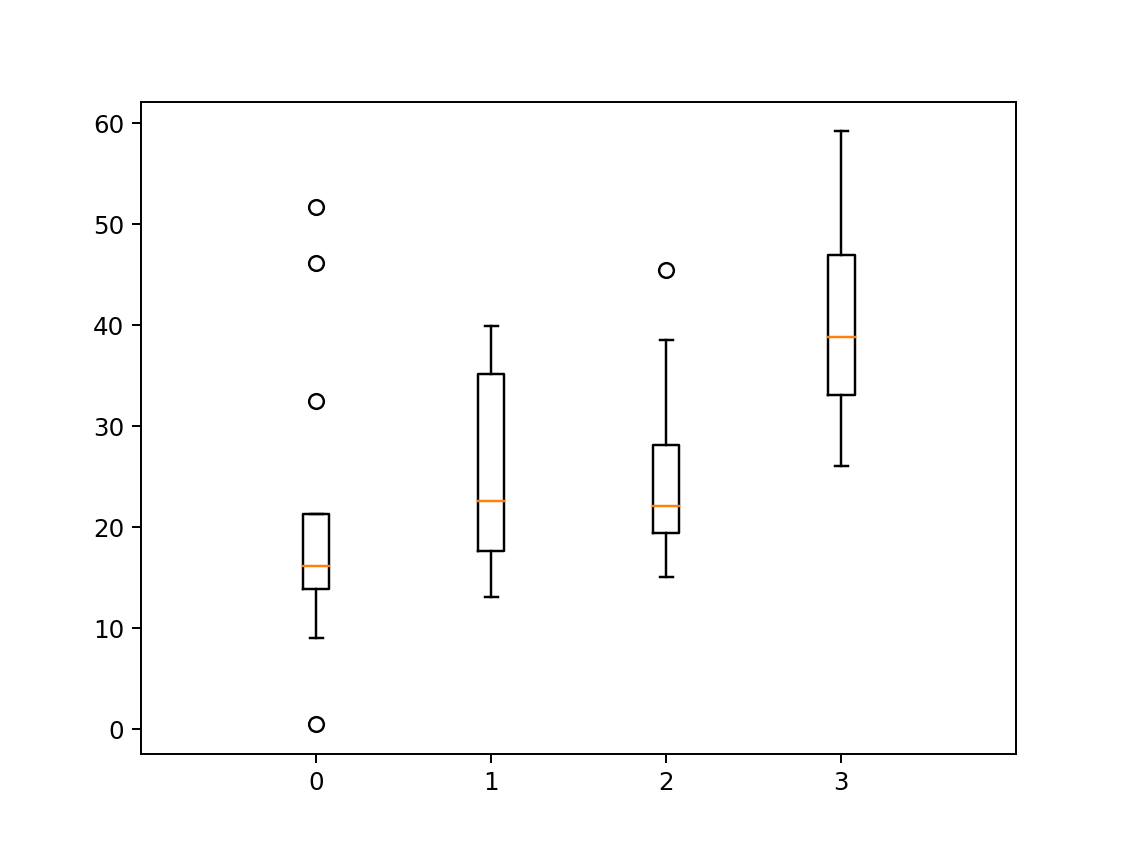

In [10]:
# Here all the function 'turn_angle_relative_to_stim_intensity' is called which does what the name says.
# First it is called using the experimental data
turn_angle_relative_to_stim_intensity_exp = \
                turn_angle_relative_to_stim_intensity_all_func(stim_exp, theta_exp, scoots_exp)

C:\Users\David\AppData\Local\conda\conda\envs\pivr_publication\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: Mean of empty slice
C:\Users\David\AppData\Local\conda\conda\envs\pivr_publication\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


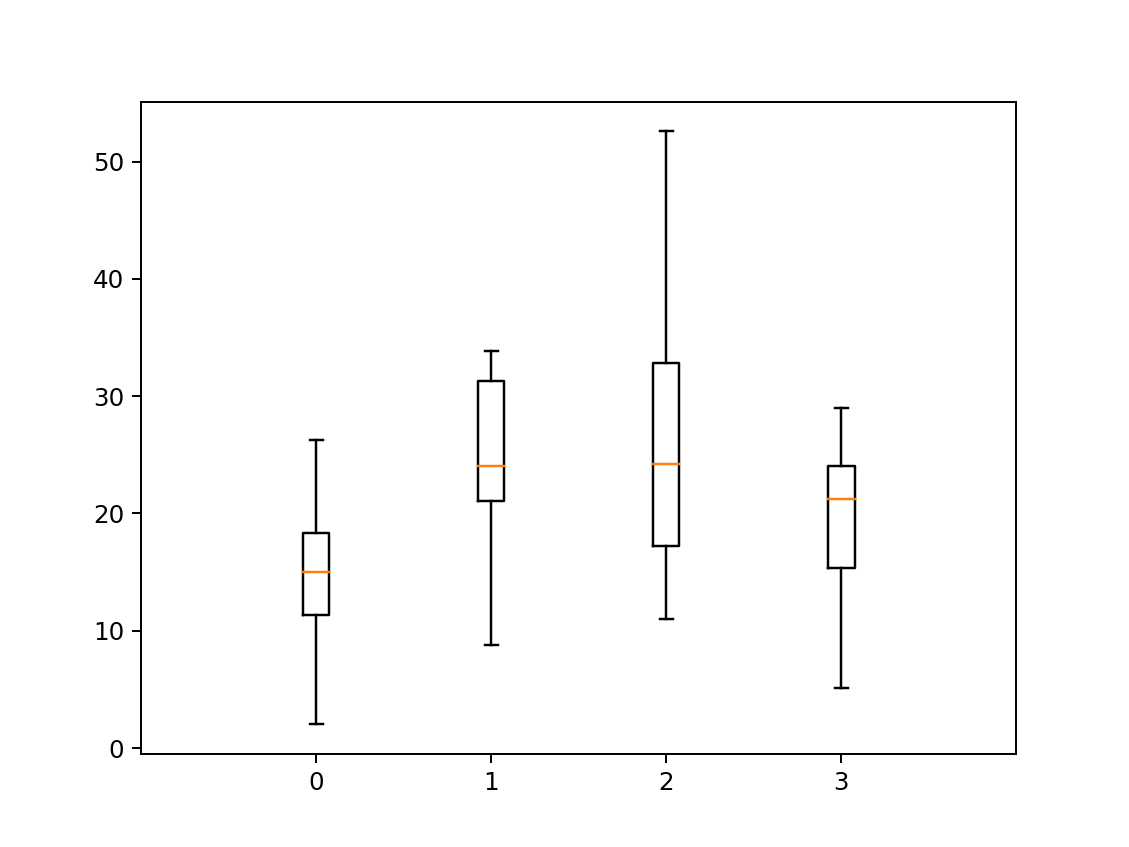

In [11]:
# .. and then using the control data
turn_angle_relative_to_stim_intensity_ctr = \
                turn_angle_relative_to_stim_intensity_all_func(stim_ctr, theta_ctr, scoots_ctr)

<IPython.core.display.Javascript object>


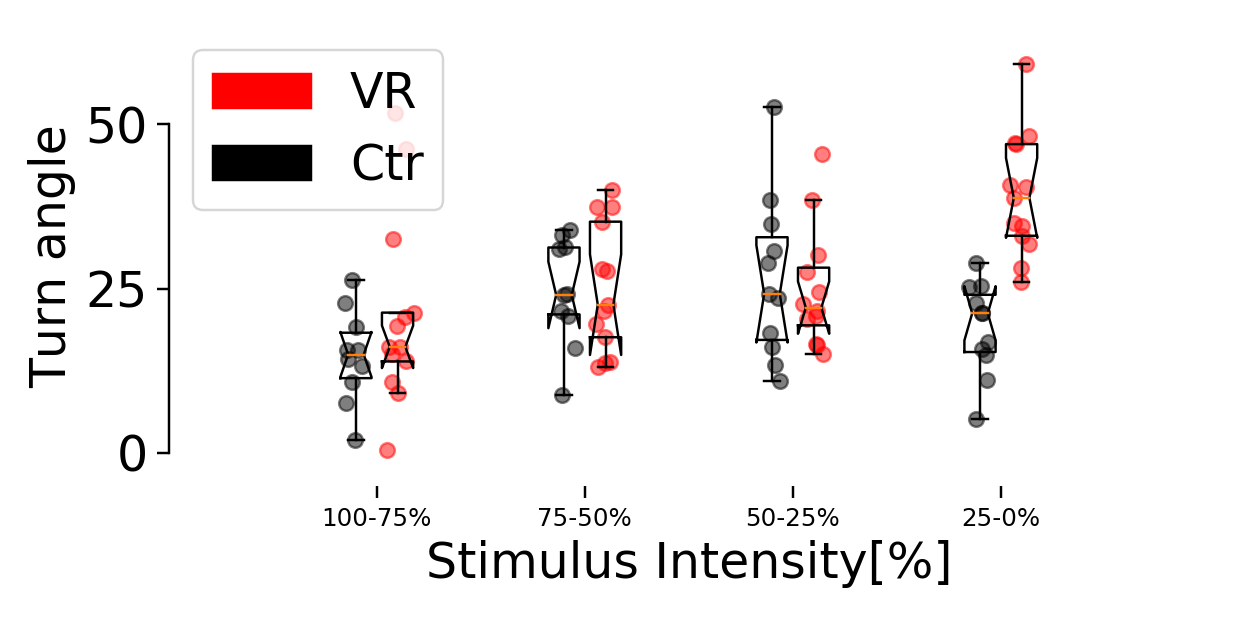

Bonferroni corrected significance for alpha of 0.05: 0.0125

lilliefors down: 0.01606998527738169 lilliefors up: 0.2
LeveneResult(statistic=1.3911102433187574, pvalue=0.25140771952713453)
Ttest_indResult(statistic=1.2577791541510084, pvalue=0.22227875044893913)

lilliefors down: 0.2 lilliefors up: 0.2
LeveneResult(statistic=0.775801298791801, pvalue=0.38839791348903685)
Ttest_indResult(statistic=0.19345960995856556, pvalue=0.8484579949704336)

lilliefors down: 0.2 lilliefors up: 0.2
LeveneResult(statistic=0.8759315906261291, pvalue=0.35995729100210694)
Ttest_indResult(statistic=-0.3535974669244128, pvalue=0.7271657520906678)

lilliefors down: 0.2 lilliefors up: 0.2
LeveneResult(statistic=0.7205524472855442, pvalue=0.4051049494478589)
Ttest_indResult(statistic=5.92883069786004, pvalue=5.754451410159046e-06)


In [12]:
# After binning the turn angle into stimulaton intensity bins, prepare a nice plot:
fig=plt.figure('Turn Angle relative to Stimulus Intensity - ALL',figsize=(7,3.5))
ax=fig.add_subplot(111)
ax.set_rasterization_zorder(1)
for i in range(turn_angle_relative_to_stim_intensity_exp.shape[0]):

    data_ctr = turn_angle_relative_to_stim_intensity_ctr[i,~np.isnan(turn_angle_relative_to_stim_intensity_ctr[i,:])]
    ax.boxplot(np.rad2deg(data_ctr),
              positions=[i-0.1], showfliers=False,notch=True,zorder=1)
    x_ctr = np.random.normal(i-0.1, 0.03, size=data_ctr.shape[0])
    ax.scatter(x=x_ctr,
              y=np.rad2deg(data_ctr),
              alpha=0.5,
              color='k',
              zorder=0)
    
    data_vr = turn_angle_relative_to_stim_intensity_exp[i,~np.isnan(turn_angle_relative_to_stim_intensity_exp[i,:])]
    ax.boxplot(np.rad2deg(data_vr),
              positions=[i+0.1], showfliers=False,notch=True,zorder=1)
    x_exp = np.random.normal(i+0.1, 0.03, size=data_vr.shape[0])
    ax.scatter(x=x_exp, 
               y=np.rad2deg(data_vr),
              alpha=0.5,
              color='r',zorder=0)
    
    # Need to correct significance for multiple comparison: Use Bonferroni and p<0.05 as significant
    significance_correct = 0.05/turn_angle_relative_to_stim_intensity_exp.shape[0]
    if i == 0: 
        print('Bonferroni corrected significance for alpha of 0.05: ' + repr(significance_correct))
                
    print("\nlilliefors down: " + repr(sm.stats.lilliefors(data_vr)[1]), 
         "lilliefors up: " + repr(sm.stats.lilliefors(data_ctr)[1])) 
    print(stats.levene(data_vr,
                      data_ctr))
    if stats.levene(data_vr,data_ctr)[1] < significance_correct:
        print(stats.ranksums(data_vr,
                          data_ctr))
    else:
        print(stats.ttest_ind(data_vr,
                          data_ctr))

ax.set_xlim(-1,turn_angle_relative_to_stim_intensity_exp.shape[0])
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['100-75%','75-50%','50-25%','25-0%'])
ax.set_ylabel('Turn angle')
ax.set_xlabel('Stimulus Intensity[%]')

ax.set_xticks([0,1,2,3])
# Can change ticklabel size here, if necessary!
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='x',which='major',bottom='off')

ax.set_ylim(-5,65)
ax.set_ylabel('Turn angle', fontsize=20)
# Only draw spine between the y-ticks
ax.spines['left'].set_bounds(0, 50)
ax.set_yticks([0,25,50])
# Can change ticklabel size here, if necessary!
ax.tick_params(axis='y', labelsize=20)
ax.set_xlabel('Stimulus Intensity[%]', fontsize=20)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_linewidth(1)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', width=1, length =5)
ax.tick_params(axis='both', which='minor', width =1,length =3)

# make some patches for the legend
red_circle = mpatches.Circle((0,0),color='red', label='VR')
black_circle = mpatches.Circle((0,0),color='k', label='Ctr')
ax.legend(handles=[red_circle,black_circle],fontsize=20, loc=2)

fig.tight_layout()
if save_plot:
    fig.savefig(Path(target_path, 'Fig4g.eps'), rasterized=True, dpi=300)

After showing above that at low light intensities fish increase their reorientation angle we now distinguish between scoots where fish just experienced a decrease (downgradient) or increase (upgradient) in light intensity

In [13]:
def turn_angle_relative_to_stim_intensity_func(stimulation,
                                                 all_angles,
                                                 scoot_indexes,
                                                 downgradient = True):
    """    
    This function prepares data for Figure 4e - it puts the theta of each scoot into bins depending on
    the experienced light intensity (0-20%, 0-40% etc.)
    
    In addition it sorts for experienced stimulation: if fish experienced a decrease in light intensity
    in the previous scoot, this is termed "Downgradient", otherwise (it's never going to be the same, so it
    really is binary) the fish moved "Upgradient".
    """
    bin_number = 4
    max_possible_stim_value = 40000
    
    DOWNGRADIENT = downgradient

    bin_one = []
    bin_two = []
    bin_three = []
    bin_four = []

    mean_angle_relative_to_stimulus = np.zeros((bin_number,stimulation.shape[1]))
    mean_angle_relative_to_stimulus.fill(np.nan)

    #What is the absolute turn angle just after the experienced stimulation intensity? ?
    abs_angle_cor = shared_functions.transpose_angle_to_2pi(all_angles)
    for i_experiment in range(stimulation.shape[1]):
        bin_one_temp = []
        bin_two_temp = []
        bin_three_temp = []
        bin_four_temp = []
        turn_angle = []
        for i_angle in range(1,len(abs_angle_cor[i_experiment])):
            turn_angle.append(shared_functions.calc_angle_diff_2(abs_angle_cor[i_experiment][i_angle], 
                                              abs_angle_cor[i_experiment][i_angle-1]))

        for i_scoot in range(1,len(scoot_indexes[i_experiment])-1):
            if DOWNGRADIENT:
                # put in a if that filters if fish goes up or downgradient.
                if stimulation[scoot_indexes[i_experiment][i_scoot], i_experiment] \
                    < stimulation[scoot_indexes[i_experiment][i_scoot-1], i_experiment] \
                   and stimulation[scoot_indexes[i_experiment][i_scoot], i_experiment] \
                    < stimulation[scoot_indexes[i_experiment][i_scoot-2], i_experiment] \
                   and stimulation[scoot_indexes[i_experiment][i_scoot], i_experiment] \
                    < stimulation[scoot_indexes[i_experiment][i_scoot-3], i_experiment]:
                        
                    if stimulation[scoot_indexes[i_experiment][i_scoot], i_experiment] <= max_possible_stim_value/bin_number*1:
                        bin_one_temp.append(abs(turn_angle[i_scoot]))
                    elif stimulation[scoot_indexes[i_experiment][i_scoot], i_experiment]  <= max_possible_stim_value/bin_number*2:
                        bin_two_temp.append(abs(turn_angle[i_scoot]))
                    elif stimulation[scoot_indexes[i_experiment][i_scoot], i_experiment]  <= max_possible_stim_value/bin_number*3: 
                        bin_three_temp.append(abs(turn_angle[i_scoot]))
                    elif stimulation[scoot_indexes[i_experiment][i_scoot], i_experiment]  <= max_possible_stim_value/bin_number*4: 
                        bin_four_temp.append(abs(turn_angle[i_scoot]))
            else:
                # put in a if that filters if fish goes up or downgradient.
                if stimulation[scoot_indexes[i_experiment][i_scoot], i_experiment]  \
                    > stimulation[scoot_indexes[i_experiment][i_scoot-1], i_experiment] \
                   and stimulation[scoot_indexes[i_experiment][i_scoot], i_experiment] \
                    > stimulation[scoot_indexes[i_experiment][i_scoot-2], i_experiment] \
                   and stimulation[scoot_indexes[i_experiment][i_scoot], i_experiment] \
                    > stimulation[scoot_indexes[i_experiment][i_scoot-3], i_experiment]:
                        
                    if stimulation[scoot_indexes[i_experiment][i_scoot], i_experiment] <= max_possible_stim_value/bin_number*1:
                        bin_one_temp.append(abs(turn_angle[i_scoot]))
                    elif stimulation[scoot_indexes[i_experiment][i_scoot], i_experiment]  <= max_possible_stim_value/bin_number*2:
                        bin_two_temp.append(abs(turn_angle[i_scoot]))
                    elif stimulation[scoot_indexes[i_experiment][i_scoot], i_experiment]  <= max_possible_stim_value/bin_number*3: 
                        bin_three_temp.append(abs(turn_angle[i_scoot]))
                    elif stimulation[scoot_indexes[i_experiment][i_scoot], i_experiment]  <= max_possible_stim_value/bin_number*4: 
                        bin_four_temp.append(abs(turn_angle[i_scoot]))

        bin_one.append(bin_one_temp)
        bin_two.append(bin_two_temp)
        bin_three.append(bin_three_temp)
        bin_four.append(bin_four_temp)
        ##############################
        # INVERTING THE ORDER HERE COMPARED TO DISTANCE/TURN ANGLE
        mean_angle_relative_to_stimulus[-1,i_experiment] = np.nanmean(np.asarray(bin_one_temp))
        mean_angle_relative_to_stimulus[-2,i_experiment] = np.nanmean(np.asarray(bin_two_temp))
        mean_angle_relative_to_stimulus[-3,i_experiment] = np.nanmean(np.asarray(bin_three_temp)) 
        mean_angle_relative_to_stimulus[-4,i_experiment] = np.nanmean(np.asarray(bin_four_temp))
    fig=plt.figure()
    ax=fig.add_subplot(111)
    for i in range(bin_number):
        ax.boxplot(np.rad2deg(
            mean_angle_relative_to_stimulus[i,~np.isnan(mean_angle_relative_to_stimulus[i,:])]),positions=[i])

    ax.set_xlim(-1,bin_number)

    return(mean_angle_relative_to_stimulus)

C:\Users\David\AppData\Local\conda\conda\envs\pivr_publication\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: Mean of empty slice
C:\Users\David\AppData\Local\conda\conda\envs\pivr_publication\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
C:\Users\David\AppData\Local\conda\conda\envs\pivr_publication\lib\site-packages\ipykernel_launcher.py:82: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


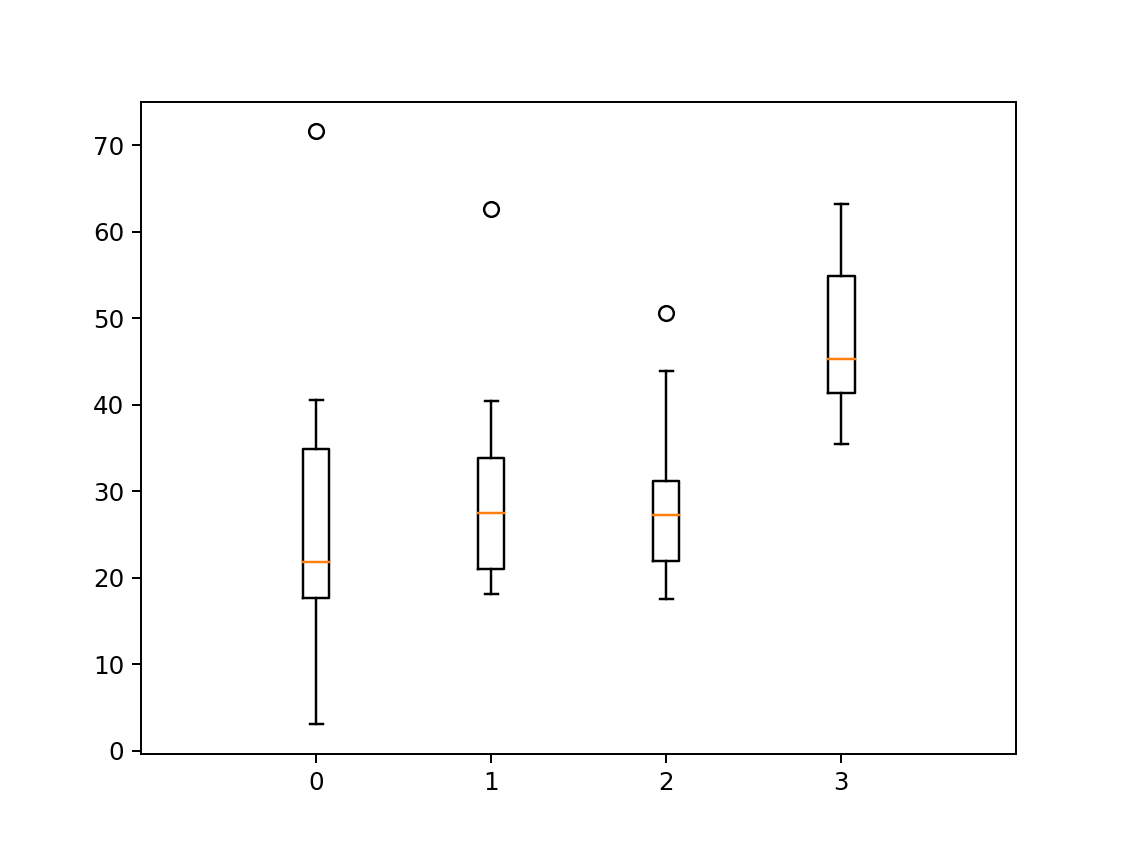

In [14]:
turn_angle_relative_to_stim_intensity_downgradient_exp = turn_angle_relative_to_stim_intensity_func(
                                                                                                stim_exp, 
                                                                                                theta_exp,
                                                                                                scoots_exp,
                                                                                                downgradient=True)

C:\Users\David\AppData\Local\conda\conda\envs\pivr_publication\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: Mean of empty slice
C:\Users\David\AppData\Local\conda\conda\envs\pivr_publication\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice
C:\Users\David\AppData\Local\conda\conda\envs\pivr_publication\lib\site-packages\ipykernel_launcher.py:82: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


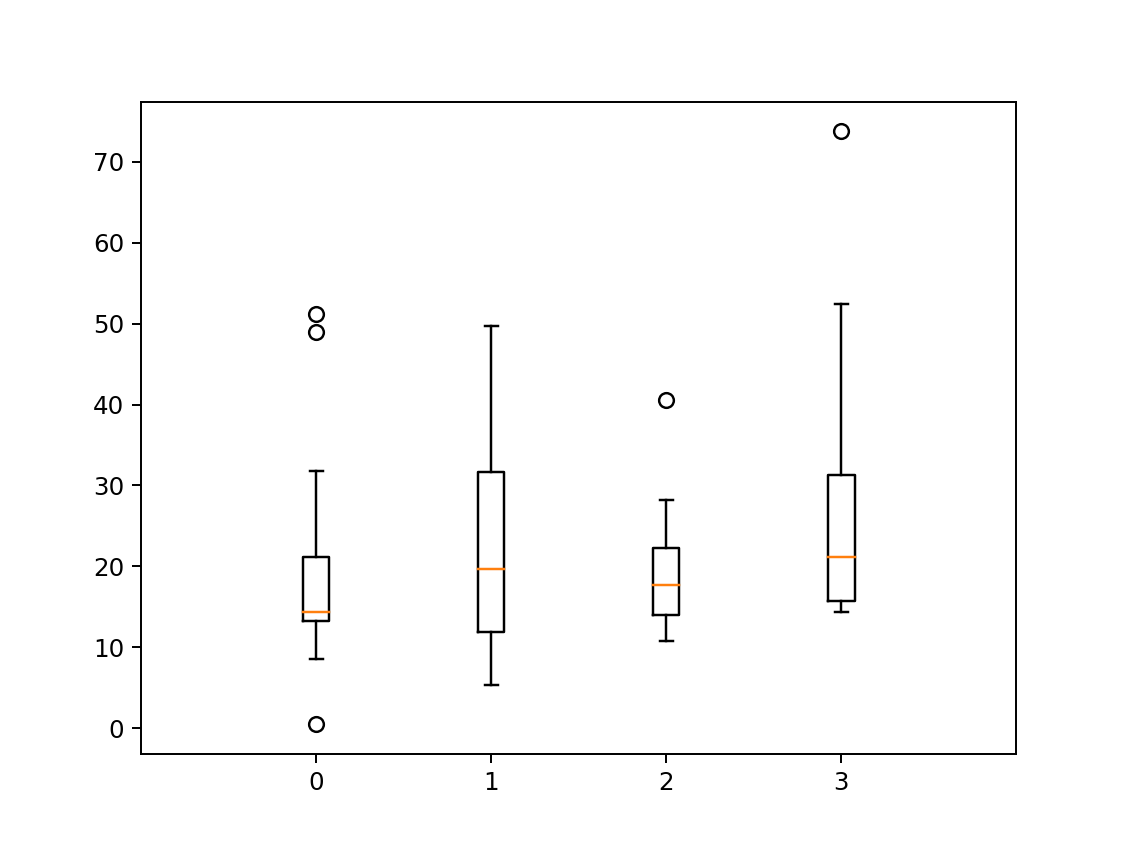

In [15]:
turn_angle_relative_to_stim_intensity_upgradient_exp = turn_angle_relative_to_stim_intensity_func(
                                                                                stim_exp, 
                                                                                theta_exp,
                                                                                scoots_exp,
                                                                                downgradient=False)

<IPython.core.display.Javascript object>


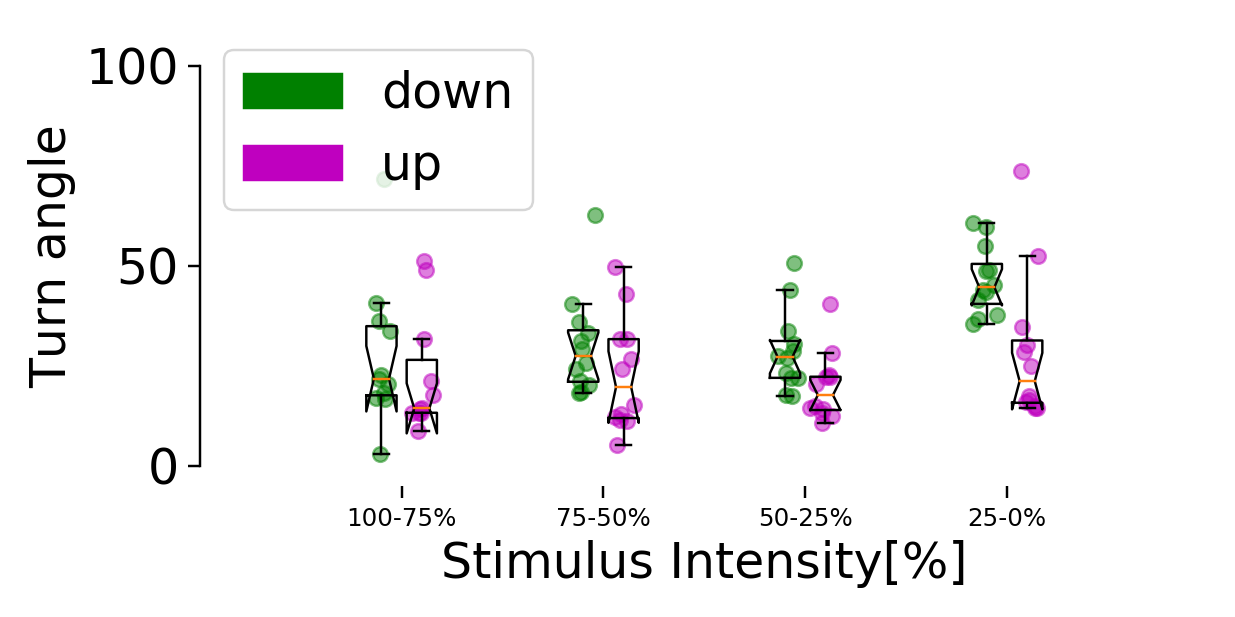

Bonferroni corrected significance alpha for 0.05: 0.0125

lilliefors down: 0.07671977899779248 lilliefors up: 0.031406045430865275
LeveneResult(statistic=0.09810273502085207, pvalue=0.7573613385952652)
Ttest_relResult(statistic=1.7228942834676628, pvalue=0.1156319735277432)

lilliefors down: 0.2 lilliefors up: 0.14731260465130946
LeveneResult(statistic=0.6822706518527532, pvalue=0.41767399634139957)
Ttest_relResult(statistic=1.4349040415894205, pvalue=0.1791301228620443)

lilliefors down: 0.2 lilliefors up: 0.14598507527330642
LeveneResult(statistic=0.09624064419579739, pvalue=0.7593082909485649)
Ttest_relResult(statistic=3.023241747236368, pvalue=0.011588396512561444)

lilliefors down: 0.2 lilliefors up: 0.09230767286927571
LeveneResult(statistic=1.7223588410490553, pvalue=0.20291776094690492)
Ttest_relResult(statistic=3.179031645382599, pvalue=0.008776287589331747)


In [16]:
# Here we make the plot comparing up- and downgradient theta in stimulus intensity bins
fig=plt.figure('Turn Angle relative to Stimulus Intensity - Up vs down',figsize=(7,3.5))
ax=fig.add_subplot(111)
ax.set_rasterization_zorder(1)
for i in range(turn_angle_relative_to_stim_intensity_downgradient_exp.shape[0]):
    # As the data is dependent, have to make sure we only take datapoints (in each group) were we have
    # both the UP and DOWN condition!
    # The loop below sorts data by only taking values for e.g. up if the value in up AND down is NOT NaN!
    down_no_nan = []
    up_no_nan = []
    for j in range(turn_angle_relative_to_stim_intensity_downgradient_exp[i].shape[0]):
        if ~np.isnan(turn_angle_relative_to_stim_intensity_downgradient_exp[i][j]):
            if ~np.isnan(turn_angle_relative_to_stim_intensity_upgradient_exp[i][j]):
                down_no_nan.append(turn_angle_relative_to_stim_intensity_downgradient_exp[i][j])
                up_no_nan.append(turn_angle_relative_to_stim_intensity_upgradient_exp[i][j])
    # recast as array for easy handling!
    down_no_nan = np.asarray(down_no_nan)
    up_no_nan = np.asarray(up_no_nan)
    
    ax.boxplot(np.rad2deg(down_no_nan),
              positions=[i-0.1], showfliers=False, notch =True,zorder=1, showmeans=False)
    x_exp = np.random.normal(i-0.1, 0.03, size=down_no_nan.shape[0])
    ax.scatter(x=x_exp, 
               y=np.rad2deg(down_no_nan),
              alpha=0.5,
              color='g',
              zorder=0)
    
    ax.boxplot(np.rad2deg(up_no_nan),
              positions=[i+0.1], showfliers=False,notch =True,zorder=1, showmeans=False)
    x_ctr = np.random.normal(i+0.1, 0.03, size=up_no_nan.shape[0])
    ax.scatter(x=x_ctr,
              y=np.rad2deg(up_no_nan),
              alpha=0.5,
              color='m',
              zorder=0)

    # Need to correct significance for multiple comparison: Use Bonferroni and p<0.05 as significant
    significance_correct = 0.05/turn_angle_relative_to_stim_intensity_exp.shape[0]
    if i == 0: 
        print('Bonferroni corrected significance alpha for 0.05: ' + repr(significance_correct))
            
    print("\nlilliefors down: " + repr(sm.stats.lilliefors(down_no_nan)[1]), 
         "lilliefors up: " + repr(sm.stats.lilliefors(up_no_nan)[1])) 
    
    # Test for homogeniacity using the levene test-have to use the no-NaN array for that
    print(stats.levene(down_no_nan,
                       up_no_nan))
    '''
    The samples are dependent.
    
    The data is normally distributed (Lilliefors) and homogeneity of variance (Levene's test) is also
    not significant when multiple testing is taken into account.
    
    Therefor use t-test for dependent samples!
    '''  
    print(stats.ttest_rel(down_no_nan, up_no_nan))

    
ax.set_xlim(-1,turn_angle_relative_to_stim_intensity_downgradient_exp.shape[0])
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['100-75%','75-50%','50-25%','25-0%'])
ax.set_ylabel('Turn angle')
ax.set_xlabel('Stimulus Intensity[%]')

# Can change ticklabel size here, if necessary!
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='x',which='major',bottom='off')

ax.set_ylim(-5,110)
ax.set_yticks([0,50,100])
ax.set_ylabel('Turn angle', fontsize=20)
# Only draw spine between the y-ticks
ax.spines['left'].set_bounds(0, 100)
# Can change ticklabel size here, if necessary!
ax.tick_params(axis='y', labelsize=20)
ax.set_xlabel('Stimulus Intensity[%]', fontsize=20)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_linewidth(1)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', width=1, length =5)
ax.tick_params(axis='both', which='minor', width =1,length =3)

# make some patches for the legend
red_circle = mpatches.Circle((0,0),color='g', label='down')
black_circle = mpatches.Circle((0,0),color='m', label='up')
ax.legend(handles=[red_circle,black_circle],fontsize=20, loc=2)

fig.tight_layout()
if save_plot:
    fig.savefig(Path(target_path, 'Fig4h.eps'), rasterized=True, dpi=300)

Finally, we wondered if fish are able to orient themselves in the virtual reality by remembering where the light source was or by just increasing turn angles ($\phi$). 

For this, we defined turn index $\beta$ - See Figure 4i for a visual explanation

In [17]:
def calc_PI(positive, negative):
    """
    Calculate the Preference index going from +1 (total attraction) to -1 (total repulsion)
    and 0 (don't care)
    Takes lists of ones (or anything else)
    """
    PI = np.nan
    try: 
        PI = (len(positive)-len(negative))/(len(positive)+len(negative))
    except ZeroDivisionError:
        pass
    return(PI)

In [18]:
def turn_index_beta_relative_to_intensity_func(all_angles,
                                                 arena_center,
                                                 centroids,
                                                 scoot_indexes,
                                                 angle_rel_to_source,
                                                 stimulation,
                                                 distance_to_source = None):
    
    """
    This function checks for each scoot if the animal is turning towards the source or away from it. 
    
    Idea:
    During each scoot, the animal can either turn more or less towards the source.
    In the shared_functions.defined_counted_scoots() the following angles are calculated:
    
    animal_angle: Used coordinates 9 frames before and after peak speed to identify travelled direction. The
    9 frames should be enough for the fry to finish the scoot, these coordinates should therefore indicate
    the stops between the scoot.
    
    angle_front_source: Calculate angle between coordinates 9 frames after the peak speed and the source.
    
    Both of those angles are then converted from -pi..+pi to 0..+2pi and the difference in the angle 
    calculated. This is the angle_rel_to_source we are using here! Note, that angle_rel_to_source goes
    from -pi..+pi again!   
    
    This angle_rel_to_source is a handy measurement for how well the fish is performing in approaching the
    light source: If the angle is 0, it is approaching head on. At -pi and pi the fish is scooting 180degress
    away from the source. 
    
    We use (rough - because it introduces artifacts!) 90 degrees as a cutoff point where the fish are turning 
    towards or away from the source. 
    
    This leads to a positive beta if fish perform most scoots towards the source and a negative beta if
    most scoots are performed away from the source. And of course 0 if there is no preference.
    
    Limitiation of this appraoch: There is a distance dependency: This approach works best if we assume 
    that the scoot lenght is smaller than the curvature of the light source. This is true if the animal
    is far away from the source but becomes less true the closer the fish is to the source. We are therefore
    introducing an artifact: When being close to the source, a randomly turning animal will perform more turns
    away from the source 
    
    It also bins the data according to stimulation intensity
    """
    bin_number = 4
    max_possible_stim_value = 40000

    bin_one = []
    bin_two = []
    bin_three = []
    bin_four = []
                
    mean_angle_relative_source_int_binned = np.zeros((bin_number,stimulation.shape[1]))
    mean_angle_relative_source_int_binned.fill(np.nan)
    
    propability_turn_towards_binned = np.zeros((bin_number, stimulation.shape[1]))
    propability_turn_towards_binned.fill(np.nan)

    #What is the NEXT absolute turn angle?
    abs_angle_cor = shared_functions.transpose_angle_to_2pi(all_angles)
    # For each experiment
    for i_experiment in range(stimulation.shape[1]):
        #print(i_experiment)
        # pre-allocate some lists which will be used later
        bin_one_temp = []
        bin_two_temp = []
        bin_three_temp = []
        bin_four_temp = []
        #bin_five_temp = []
        
        turns_away_bin_one = []
        turns_towards_bin_one = []
        
        turns_away_bin_two = []
        turns_towards_bin_two = []
        
        turns_away_bin_three = []
        turns_towards_bin_three = []
        
        turns_away_bin_four = []
        turns_towards_bin_four = []

        turn_angle = []
        
        # For each scoot prepare theta - this turn angle will contain the orientation
        # relative to the source in the sign
        for i_angle in range(1,len(abs_angle_cor[i_experiment])):
            turn_angle.append(shared_functions.calc_angle_diff_2(abs_angle_cor[i_experiment][i_angle], 
                                                abs_angle_cor[i_experiment][i_angle-1]))
        
        #total = 0
        #taken = 0
        # For each scoot in the current experiment:
        for i_scoot in range(1,len(scoot_indexes[i_experiment])-1):
            #total += 1
            # Can implement a distance to source rule to try to correct for the fact that ctrl
            # fish spend a lot of time doing thigmotaxis - they're just following the round shape
            # of the petri dish which might introduce artifacts!
            #if distance_to_source[scoot_indexes[i_experiment][i_scoot], i_experiment] \
            #    < shared_functions.constants.max_distance_to_source:
            #    taken += 1
            
            if stimulation[scoot_indexes[i_experiment][i_scoot], i_experiment] <= max_possible_stim_value/bin_number*1:
                bin_one_temp.append(abs(angle_rel_to_source[i_experiment][i_scoot]))
                # directly defined turns towards and away here!
                # if turns AWAY from source (note the "abs", includes both negative and positive angles!)
                if abs(angle_rel_to_source[i_experiment][i_scoot]) > np.pi/2:
                    turns_away_bin_one.append(1)
                else:
                    turns_towards_bin_one.append(1)

            elif stimulation[scoot_indexes[i_experiment][i_scoot], i_experiment]  <= max_possible_stim_value/bin_number*2:
                bin_two_temp.append(abs(angle_rel_to_source[i_experiment][i_scoot]))
                if abs(angle_rel_to_source[i_experiment][i_scoot]) > np.pi/2:
                    turns_away_bin_two.append(1)
                else:
                    turns_towards_bin_two.append(1)

            elif stimulation[scoot_indexes[i_experiment][i_scoot], i_experiment]  <= max_possible_stim_value/bin_number*3: 
                bin_three_temp.append(abs(angle_rel_to_source[i_experiment][i_scoot]))
                if abs(angle_rel_to_source[i_experiment][i_scoot]) > np.pi/2:
                    turns_away_bin_three.append(1)
                else:
                    turns_towards_bin_three.append(1)

            elif stimulation[scoot_indexes[i_experiment][i_scoot], i_experiment]  <= max_possible_stim_value/bin_number*4: 
                bin_four_temp.append(abs(angle_rel_to_source[i_experiment][i_scoot]))
                if abs(angle_rel_to_source[i_experiment][i_scoot]) > np.pi/2:
                    turns_away_bin_four.append(1)
                else:
                    turns_towards_bin_four.append(1)
        
        mean_angle_relative_source_int_binned[0,i_experiment] = np.nanmean(np.asarray(bin_one_temp))
        mean_angle_relative_source_int_binned[1,i_experiment] = np.nanmean(np.asarray(bin_two_temp))
        mean_angle_relative_source_int_binned[2,i_experiment] = np.nanmean(np.asarray(bin_three_temp)) 
        mean_angle_relative_source_int_binned[3,i_experiment] = np.nanmean(np.asarray(bin_four_temp))

        propability_turn_towards_binned[0, i_experiment] = calc_PI(turns_towards_bin_one, turns_away_bin_one)
        propability_turn_towards_binned[1, i_experiment] = calc_PI(turns_towards_bin_two, turns_away_bin_two)
        propability_turn_towards_binned[2, i_experiment] = calc_PI(turns_towards_bin_three, turns_away_bin_three)
        propability_turn_towards_binned[3, i_experiment] = calc_PI(turns_towards_bin_four, turns_away_bin_four)
 
    fig=plt.figure()
    ax=fig.add_subplot(211)
    for i in range(bin_number):
        ax.boxplot(np.rad2deg(
            mean_angle_relative_source_int_binned[i,~np.isnan(mean_angle_relative_source_int_binned[i,:])]),positions=[i])

    ax = fig.add_subplot(212,sharex=ax)
    for i in range(bin_number):
        ax.boxplot(propability_turn_towards_binned[i,~np.isnan(propability_turn_towards_binned[i,:])], positions=[i])
    
    ax.set_xlim(-1,bin_number)
    
    return(propability_turn_towards_binned)

C:\Users\David\AppData\Local\conda\conda\envs\pivr_publication\lib\site-packages\ipykernel_launcher.py:133: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


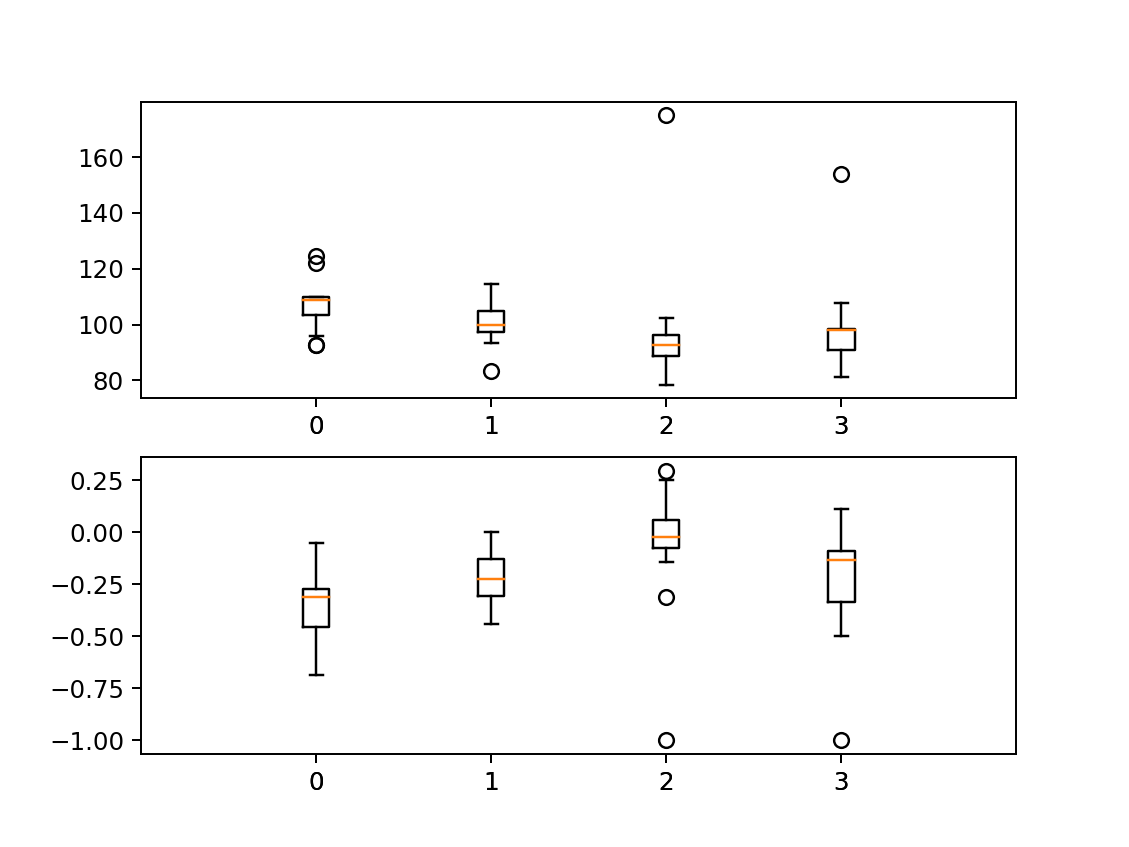

In [19]:
probablity_towards_exp = \
    turn_index_beta_relative_to_intensity_func(all_angles = theta_exp,
                                             arena_center = vr_source_exp,
                                             centroids = centroids_exp,
                                             scoot_indexes = scoots_exp,
                                             angle_rel_to_source = angle_to_light_exp,
                                             stimulation = stim_exp)

C:\Users\David\AppData\Local\conda\conda\envs\pivr_publication\lib\site-packages\ipykernel_launcher.py:134: RuntimeWarning: Mean of empty slice
C:\Users\David\AppData\Local\conda\conda\envs\pivr_publication\lib\site-packages\ipykernel_launcher.py:135: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


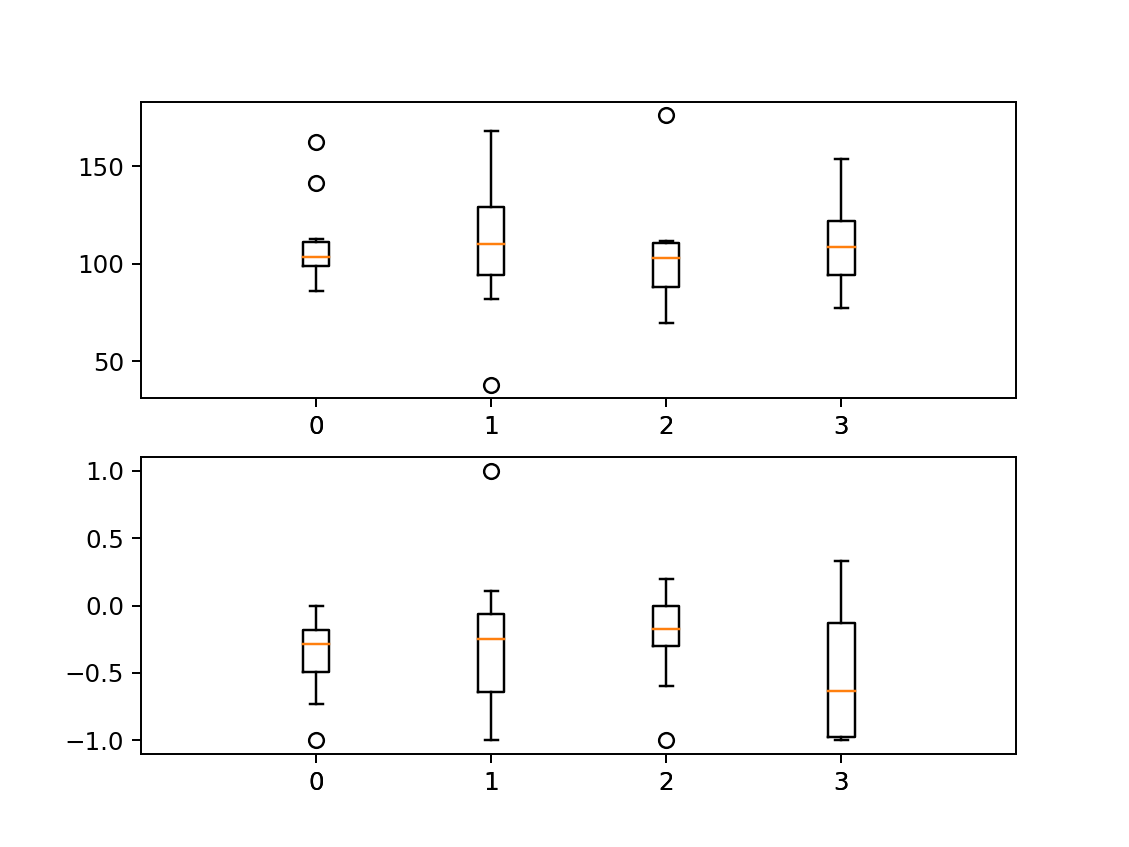

In [20]:
probablity_towards_ctr = \
    turn_index_beta_relative_to_intensity_func(all_angles = theta_ctr,
                                             arena_center = vr_source_ctr,
                                             centroids = centroids_ctr,
                                             scoot_indexes = scoots_ctr,
                                             angle_rel_to_source = angle_to_light_ctr,
                                             stimulation = stim_ctr)

<IPython.core.display.Javascript object>


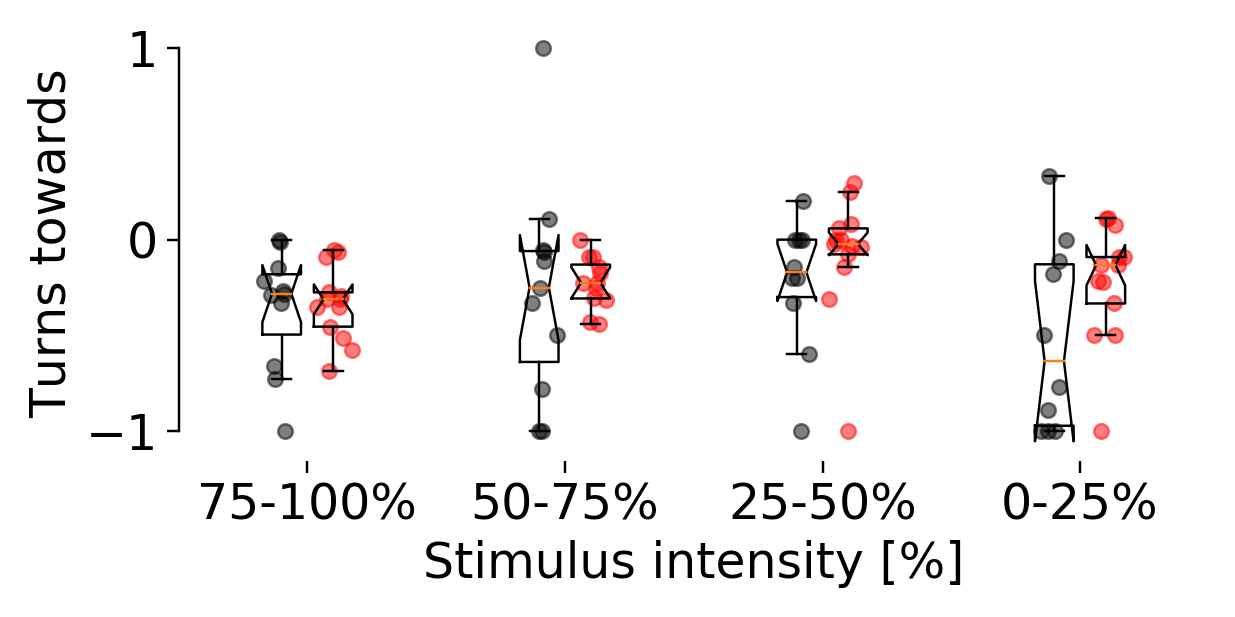

Bonferroni corrected significance alpha: 0.0125

Lillifors vr: 0.2 Lillifors ctr: 0.03784264036100658
RanksumsResult(statistic=0.550397186527205, pvalue=0.5820469779800973)

Lillifors vr: 0.2 Lillifors ctr: 0.2
RanksumsResult(statistic=-0.27695585470349865, pvalue=0.7818140034887688)

Lillifors vr: 0.013902329220673672 Lillifors ctr: 0.13623605384802007
RanksumsResult(statistic=-1.302364713186689, pvalue=0.19279173926228477)

Lillifors vr: 0.18476515997577383 Lillifors ctr: 0.2
RanksumsResult(statistic=-1.3953907641285952, pvalue=0.1628980349177952)


In [21]:
fig=plt.figure('Turn Angle relative to source intensity binned',figsize=(7,3.5))
ax=fig.add_subplot(111)
ax.set_rasterization_zorder(1)

for i in range(probablity_towards_ctr.shape[0]):
    # plot control
    data_ctr = probablity_towards_ctr[i,~np.isnan(probablity_towards_ctr[i,:])]

    ax.boxplot(data_ctr, positions=[i-0.1], showfliers=False, notch =True, zorder=1)
    x_ctr = np.random.normal(i-0.1, 0.03, size=data_ctr.shape[0])
    ax.scatter(x=x_ctr,
              y=data_ctr,
              alpha=0.5,
              color='k',zorder=0)
    
    # plot exp
    data_vr = probablity_towards_exp[i,~np.isnan(probablity_towards_exp[i,:])]
    boxplot = ax.boxplot(data_vr,
                         positions=[i+0.1], 
                         showfliers=False, 
                         notch =True, 
                         #patch_artist=True,
                         zorder=1)
    # color the boxplot
    #boxplot['boxes'][0].set_facecolor('red')
    x_exp = np.random.normal(i+0.1, 0.03, size=data_vr.shape[0])
    ax.scatter(x=x_exp, 
               y=data_vr,
              alpha=0.5,
              color='r',zorder=0)
    
    # Need to correct significance for multiple comparison: Use Bonferroni and p<0.05 as significant
    significance_correct = 0.05/probablity_towards_ctr.shape[0]
    if i == 0: 
        print('Bonferroni corrected significance alpha: ' + repr(significance_correct))
    print("\nLillifors vr: " + repr(sm.stats.lilliefors(data_vr)[1]),
         "Lillifors ctr: " + repr(sm.stats.lilliefors(data_ctr)[1]))
    #print(stats.levene(data_ctr,
    #                   data_vr))
    #if stats.levene(data_ctr,data_vr)[1] < significance_correct:
    # One of the levene tests and two of the Lilliefors test is significant > all need to be non-parametric
    print(stats.ranksums(data_ctr,
                          data_vr))
    #else:
    #    print(stats.ttest_ind(data_ctr,
    #                          data_vr))    

ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['75-100%','50-75%','25-50%','0-25%'])
ax.set_xlim(-0.5,probablity_towards_ctr.shape[0]-0.5)
# Can change ticklabel size here, if necessary!
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='x',which='major',bottom='off')

ax.set_ylabel('Turns towards', fontsize=20)
# Only draw spine between the y-ticks
ax.spines['left'].set_bounds(-1,1)
# set yticks
ax.set_yticks([-1,0,1])
# Can change ticklabel size here, if necessary!
ax.tick_params(axis='y', labelsize=20)
ax.set_xlabel('Stimulus intensity [%]', fontsize=20)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_linewidth(1)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', width=1, length =5)
ax.tick_params(axis='both', which='minor', width =1,length =3)

# make some patches for the legend
red_circle = mpatches.Circle((0,0),color='red', label='VR')
black_circle = mpatches.Circle((0,0),color='k', label='Ctr')
#ax.legend(handles=[red_circle,black_circle],fontsize=20, loc=2)

#ax.grid(which='major', axis='y', linestyle='--', alpha = 0.5, zorder=0)

fig.tight_layout()

if save_plot:
    fig.savefig(Path(target_path, 'Fig4j.eps'), rasterized=True, dpi=200)

<IPython.core.display.Javascript object>


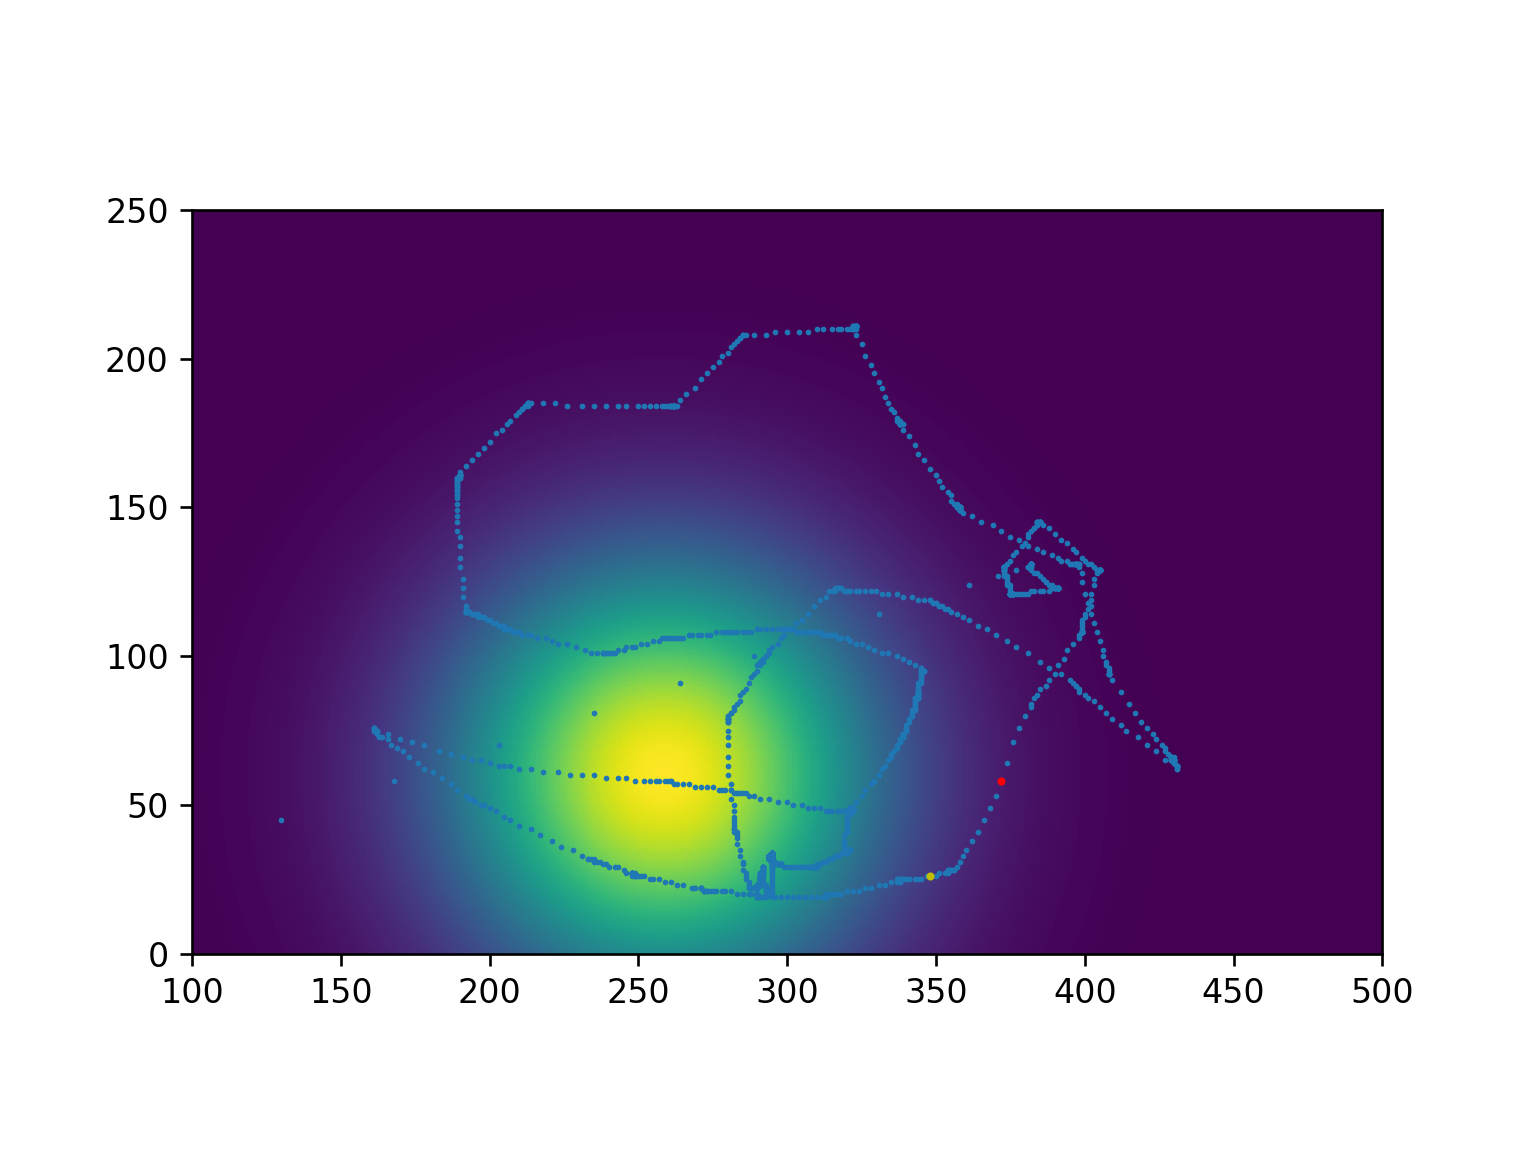

-1.4407275718402666
-0.8261918462653135


In [75]:
# Use this to visualize some parameters. Need to uncomment in 'find_theta' function the last two
# return parameters to get the centroid coordinates and the arena which are needed for plotting.
# This might help with getting an understanding how the different parameters play together
'''
exp_centroids = temp
print(exp_centroids.shape)
arenas = temp2
print(arenas.shape)

fig, ax = plt.subplots()
ax.imshow(arenas[:,:,0])
ax.scatter(y=exp_centroids[:,0,0],x=exp_centroids[:,1,0],s=0.5)
#for i in range(len(scoots_exp[0])):
i = 5
ax.scatter(y=exp_centroids[scoots_exp[0][i],0,0],
           x=exp_centroids[scoots_exp[0][i],1,0], c='r', s=2)
i+=1
ax.scatter(y=exp_centroids[scoots_exp[0][i],0,0],
           x=exp_centroids[scoots_exp[0][i],1,0], c='y', s=2)
    
ax.set_xlim(100,500)
ax.set_ylim(0,250)

print(angle_to_light_exp[0][i-1])
print(angle_to_light_exp[0][i+1])
'''